# Captcha Recognition

In [11]:
from fastai.vision.all import *
from fastai.text.all import *
from datasets import Dataset
from captcha.image import ImageCaptcha
import random
import string

In [12]:
from src.utils import *
from src.metrics import *

# Dataset

Here we will be training our model to recognize captcha. 

In [13]:
# 2. Create a fake CAPTCHA dataset
def create_captcha_dataset(size=100):
    generator = ImageCaptcha(width=160, height=60)
    data = []
    for _ in range(size):
        label = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
        img = generator.generate_image(label)
        data.append({'image': img, 'label': label})  # Using our custom class
    return Dataset.from_list(data)


In [14]:

# 3. Generate the dataset
ds = create_captcha_dataset(1000)

<Axes: title={'center': '2MQPR'}>

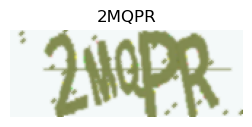

In [15]:
show_image(ds[0]['image'],title=ds[0]['label'],figsize=(3,5))

# DataLoaders

For dataloaders, we need to create data types. Since, we wanted to use Transformation pipeline which converts tensors from objects and viceversa. It's advisable to create a custom Transform to handle labels

In [16]:
class CaptchaStr(str):
    def show(self, ctx=None, **kwargs):
        return show_title(self, ctx=ctx)

class TokenizeLabel(Transform):
    vocab = list(string.ascii_uppercase + string.digits)
    def __init__(self):
        self.stoi = {v: k for k, v in enumerate(self.vocab)}

    def encodes(self, x: str):
        return TensorText(tensor([self.stoi[c] for c in x]))

    def decodes(self, x: TensorText):
        indices = x.detach().cpu().flatten().tolist()
        return CaptchaStr(''.join(self.vocab[int(i)] for i in indices))


In [17]:
dblock = DataBlock(
    blocks=(ImageBlock, TransformBlock(type_tfms=TokenizeLabel())),
    get_x=lambda o: o['image'],
    get_y=lambda o: o['label'],  # Already a CaptchaLabel instance
    splitter=RandomSplitter(),
    item_tfms=None,
    batch_tfms=[Normalize()]
)

# 7. Create DataLoaders
dls = dblock.dataloaders(ds, bs=16)

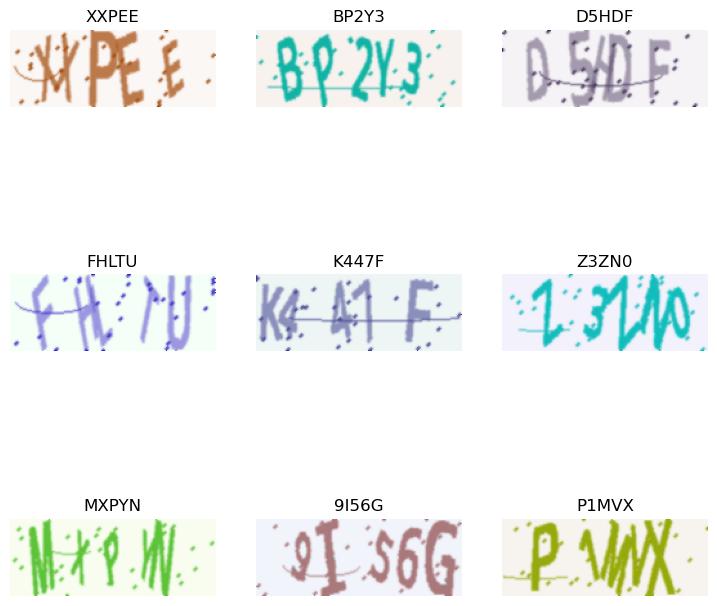

In [18]:
dls.show_batch()

## Modeling

In [19]:

# 7. Improved CNN Backbone
class CNNBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        # First conv block (input: 3x60x160)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 60x160 -> 30x80
        )
        # Second conv block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 30x80 -> 15x40
        )
        # Third conv block
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Added an extra conv layer
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))  # 15x40 -> 7x40
        )
        # Fourth conv block
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Added an extra conv layer
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))  # 7x40 -> 3x40
        )
        # Reduce height to 1, keep width
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 40))  # Force output width to be 40

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.adaptive_pool(x)
        return x

In [20]:
class CRNN(nn.Module):
    def __init__(self, num_chars):
        super().__init__()
        self.cnn = CNNBackbone()
        # CNN output: [bs, 512, 1, 40]
        lstm_input_size = 512
        hidden_size = 256
        self.num_chars = num_chars

        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            lstm_input_size,
            hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=False,
            dropout=0.2
        )

        # Initialize LSTM parameters with better values
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            if 'bias' in name:
                nn.init.zeros_(param)
                # Set forget gate bias to 1 (helps with vanishing gradients)
                n = param.size(0)
                param.data[n//4:n//2].fill_(1.0)

        # Output layer
        self.fc = nn.Linear(hidden_size * 2, num_chars + 1)  # +1 for blank

        # Initialize output layer with better values
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

        # CRITICAL: Set bias against blank prediction
        # This helps prevent the "blank collapse" problem
        with torch.no_grad():
            self.fc.bias[num_chars] = -2.0  # Strong negative bias for blank
            # Give a slight positive bias to actual characters
            for i in range(num_chars):
                self.fc.bias[i] = 0.5  # Small positive bias for real characters

    def forward(self, images):
        # Extract CNN features
        features = self.cnn(images)  # [bs, 512, 1, 40]
        bs, C, H, W_seq = features.size()
        assert H == 1, "CNN output height must be 1"

        # Reshape for LSTM: [seq_len, batch_size, features]
        features = features.squeeze(2)      # [bs, 512, 40]
        features = features.permute(2, 0, 1)  # [40, bs, 512]

        # Pass through LSTM
        lstm_out, _ = self.lstm(features)  # [40, bs, 512]

        # Pass through final linear layer
        logits = self.fc(lstm_out)  # [40, bs, num_chars+1]

        # Apply log softmax for CTC loss
        log_probs = F.log_softmax(logits, dim=2)

        # Debug prints - uncomment to see activation distributions
        # print(f"Logits min: {logits.min().item()}, max: {logits.max().item()}, mean: {logits.mean().item()}")
        # print(f"Log_probs min: {log_probs.min().item()}, max: {log_probs.max().item()}, mean: {log_probs.mean().item()}")

        return log_probs

# Loss

Loss is the most critical part of modeling. It differentiates from good prediction from bad. Here is a simple way to define CTCLoss

In [55]:
class CTCLossFlat(nn.Module):
    def __init__(self, blank_token=0, pad_token=-1):
        super().__init__()
        self.blank_token = blank_token
        self.pad_token = pad_token
        self.ctc = nn.CTCLoss(blank=blank_token, reduction='mean', zero_infinity=True)

    def forward(self, log_probs, targets):
        """
        log_probs: [T, B, C] — already in CTC-ready shape
        targets:   [B, S] — padded label indices
        """
        T, B, C = log_probs.shape  # ✅ correct: T = 40, B = 16
    
        # Input lengths = full time steps (T) for each batch
        input_lengths = torch.full((B,), T, dtype=torch.long, device=log_probs.device)
    
        # Target lengths = number of non-pad tokens
        target_lengths = (targets != self.pad_token).sum(dim=1)
    
        # Flatten targets
        targets_flat = torch.cat([t[t != self.pad_token] for t in targets])
    

        return self.ctc(log_probs, targets_flat, input_lengths, target_lengths)

    def activation(self, x):
        return F.log_softmax(x, dim=-1)

    def decodes(self, x):
            if x.ndim == 3: x = x.permute(1, 0, 2)  # [B, T, C]
            preds = x.argmax(-1)  # [B, T]
    
            decoded = []
            for pred in preds:
                tokens = []
                prev = self.blank_token
                for p in pred.cpu().tolist():
                    if p != prev and p != self.blank_token:
                        tokens.append(p)
                    prev = p
                decoded.append(tokens)
            
            # Pad sequences to max length in batch and wrap in TensorText
            max_len = max(len(seq) for seq in decoded)
            padded = torch.full((len(decoded), max_len), self.pad_token, device=x.device)
            for i, seq in enumerate(decoded):
                padded[i, :len(seq)] = torch.tensor(seq, device=x.device)
            
            return TensorText(padded)  # 🔑 Wrap in TensorText


# Training

In [56]:
model = CRNN(len(dls.vocab))
loss_func = CTCLossFlat(blank_token = 0)

def split_params(model):
    return [
        params(model.cnn),         # CNN layers - lower learning rate
        params(model.lstm),        # LSTM layers - medium learning rate
        params(model.fc)           # Final layer - higher learning rate
    ]

In [81]:
learn = Learner(
        dls,
        model,
        loss_func=loss_func,
        splitter=split_params,
        metrics=[CTCAccuracy(CTCDecoder(dls.vocab))],
        wd=1e-3  # Reduced weight decay
)

SuggestedLRs(valley=0.0012022644514217973)

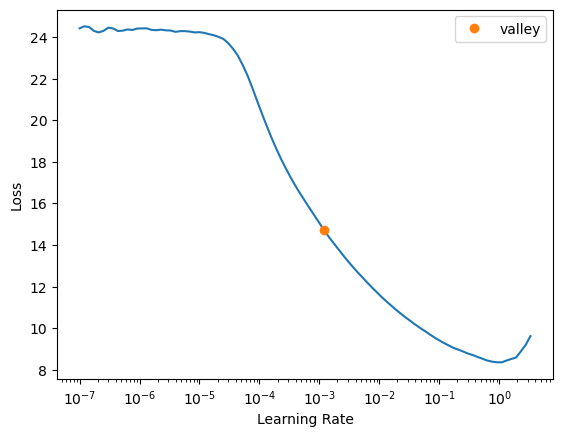

In [82]:
learn.lr_find()

In [83]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,acc,time
0,5.699660,3.764331,0.000000,00:02
1,4.239408,3.723870,0.000000,00:02
2,3.860534,3.732362,0.000000,00:02
3,3.752717,3.730798,0.000000,00:02
4,3.686547,3.760492,0.000000,00:02
5,3.657431,3.810178,0.000000,00:02
6,3.580733,3.506015,0.000000,00:02
7,3.364519,3.111249,0.000000,00:02
8,2.587488,1.889174,0.000000,00:02
9,1.400702,0.675926,0.255000,00:03


In [88]:
from plum import dispatch

@dispatch
def show_results(x:TensorImage, y:TensorText, samples, outs, ctxs=None, max_n=6, **kwargs):
    
    # ctxs = get_grid(min(len(samples), max_n)) if not ctxs else ctxs
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n))

    for i, ((img, tgt), pred) in enumerate(zip(samples, outs)):
        ctx = ctxs[i]
        img.show(ctx=ctx)
        
        # Decode target and prediction from TensorText
        tgt_str = CaptchaStr(tgt)
        pred_str = CaptchaStr(pred[0])
        
        ctx.set_title(f"Actual: {tgt_str}\nPred: {pred_str}", fontsize=8)
    
    return ctxs

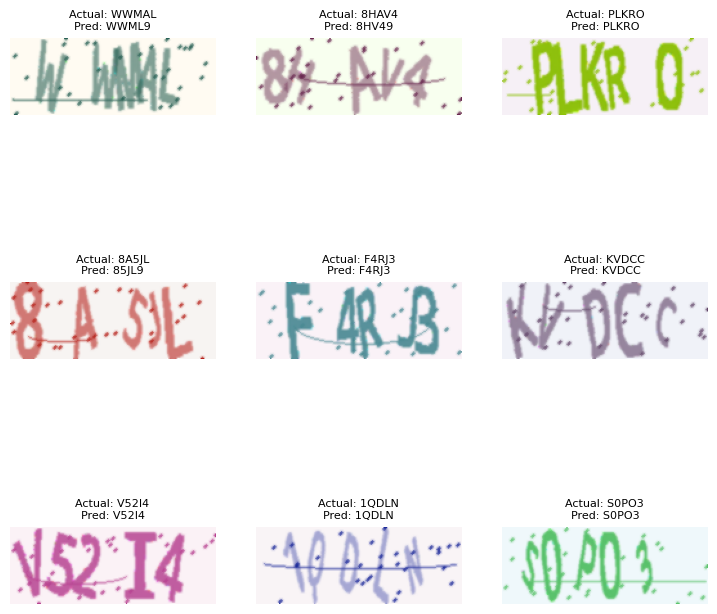

In [89]:
learn.show_results()